# Lets create a Recommendation system for the Henry coefficients of porous materials

In [289]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import pygaps
import scipy
from scipy.sparse.linalg import svds
import tensorflow as tf

## We will use the Henry Coefficient matrix, created in `HenryMatrix.ipynb`

In [3]:
henry_df = pd.read_csv('data/henry_matrix_df.csv')
henry_df.set_index(list(henry_df)[0], inplace=True)
henry_df.head(10)

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K,ATUOYWHBWRKTHZ-UHFFFAOYSA-N_298K,HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K,UFHFLCQGNIYNRP-UHFFFAOYSA-N_298K,MWUXSHHQAYIFBG-UHFFFAOYSA-N_298K,XLYOFNOQVPJJNP-UHFFFAOYSA-N_298K,...,VGGSQFUCUMXWEO-UHFFFAOYSA-N_298K,QGZKDVFQNNGYKY-UHFFFAOYSA-N_298K,CSCPPACGZOOCGX-UHFFFAOYSA-N_298K,IJDNQMDRQITEOD-UHFFFAOYSA-N_298K,NNPPMTNAJDCUHE-UHFFFAOYSA-N_298K,BDERNNFJNOPAEC-UHFFFAOYSA-N_298K,YXFVVABEGXRONW-UHFFFAOYSA-N_298K,OFBQJSOFQDEBGM-UHFFFAOYSA-N_298K,RAHZWNYVWXNFOC-UHFFFAOYSA-N_298K,VXNZUUAINFGPBY-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.627878,0.208338,0.240586,NaN,13.210824,15.439162,0.001502,3.488718,NaN,9.316021,...,1.370187,0.958055,NaN,NaN,NaN,NaN,NaN,NaN,18.192574,NaN
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,14.439543,0.613339,0.770274,0.096864,52.095266,80.817935,NaN,NaN,NaN,NaN,...,3.116040,442.583688,NaN,257.522347,NaN,NaN,NaN,NaN,NaN,97.061748
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,0.982443,0.286726,0.058081,0.188162,NaN,NaN,NaN,3.694219,NaN,2.344581,...,40.043567,1.409460,1.462035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,2.198198,0.206994,0.735486,0.097778,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,66.204409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,4.358242,0.250075,0.606177,0.238141,478.099058,25.528800,86.774658,0.077938,10.083501,2315.499440,...,36.576317,362.456884,NaN,0.267295,386.886107,NaN,NaN,NaN,34.533257,NaN
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,3.040278,NaN,14.129264,NaN,NaN,NaN,51.060147,7.839395,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.104883,NaN
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,1.015902,0.175303,0.351781,NaN,NaN,0.219119,1.156680,0.072082,0.171605,0.306919,...,NaN,37.412808,NaN,NaN,NaN,NaN,NaN,NaN,16.823514,NaN
NIST-MATDB-5ab0dbe0639729711750ef4b97715f0f,2.449089,0.195309,0.599994,0.122395,NaN,NaN,NaN,0.720796,NaN,493.780606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NIST-MATDB-0d52b4312e8dd98a53fcfaba14cd0e82,NaN,NaN,NaN,NaN,124.576242,88.002547,NaN,1.429994,NaN,52.073153,...,NaN,NaN,NaN,224.890244,NaN,NaN,NaN,NaN,NaN,125.484691


## Lets also define a function that will randomly split our data into <i>k</i> folds

In [186]:
def k_fold_split(henry_df, k, max_iter=1000):
    assert k > 1, 'Choose a `k` greater than 1, otherwise this function is pointless'
    matrix = henry_df.values
    fold_matrix = np.full_like(matrix, np.nan, dtype=np.double)
    col_bool = True
    n_col = 0
    while col_bool:
        n_col += 1
        col_bool = False
        for i_row in range(matrix.shape[0]):
            # Grabs all available indices in row `i_row`
            j_indices = np.where(~np.isnan(matrix[i_row,:]))[0]
            # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
            while len(j_indices) >= k:
                for fold in range(k):
                    j = np.random.randint(0, len(j_indices))
                    fold_matrix[i_row, j_indices[j]] = fold
                    j_indices = np.delete(j_indices, j)
            # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
            for j in j_indices:
                fold_matrix[i_row, j] = np.int(np.random.rand()*k)
        # We make sure we have enough data points in the columns as well
        for j_col in range(matrix.shape[1]):
            vals = np.unique(fold_matrix[:, j_col])
            #print(len(vals[~np.isnan(vals)]))
            if len(vals[~np.isnan(vals)]) < k:
                #print(j_col)
                col_bool = True
                break
        # If too many iteration are performed an Exception is raised.
        if n_col > max_iter:
            raise Exception('Maximum number of iterations reached. Try changing the `max_iter` argument.')
    
    print('Number of iterations required to split data into {}-folds: {}'.format(k, n_col))
    return fold_matrix

fold_matrix = k_fold_split(henry_df, 3, max_iter=1e4)

Number of iterations required to split data into 3-folds: 14


In [178]:
np.count_nonzero(~np.isnan(henry_df.values[:,8]))

5

In [184]:
henry_df.mask(fold_matrix==0).values

array([[        nan,         nan,         nan, ...,         nan,
        18.19257397,         nan],
       [        nan,  0.6133393 ,  0.77027446, ...,         nan,
                nan, 97.06174838],
       [        nan,  0.28672616,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.65160471,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

### Lets start setting up the Recommender System algorithm

In [536]:
def recsys_rmse(r, p, q, lambd):
    return (r - np.transpose(q) * p)**2 + lambd * (np.linalg.norm(p)**2 + np.linalg.norm(q)**2)

In [537]:
def predict(x, y, mu, b_i, b_u):
    #print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
    return mu + b_i + b_u + (x.T).dot(y)

In [538]:
def predict_all(X, Y, mu, b_i, b_u):
    predictions = np.zeros((X.shape[1], Y.shape[1]))
    for u in range(X.shape[1]):
        for i in range(Y.shape[1]):
            predictions[u, i] = predict(X[:,u], Y[:,i], mu, b_i[i], b_u[u])
    return predictions

#### ALS methods implemented according to http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

X_shape: (3, 86)	Y_shape: (3, 27)
Train Error on iteration 0: 468.68027429399086
-------------
Train Error on iteration 1000: 38.252225218673956
-------------
Train Error on iteration 2000: 35.93258454085263
-------------
Train Error on iteration 3000: 35.474210490959706
-------------
Train Error on iteration 4000: 35.220791929632085
-------------
Train Error on iteration 5000: 35.056567237001985
-------------
Train Error on iteration 6000: 34.941842252390195
-------------
Train Error on iteration 7000: 34.85809471959162
-------------
Train Error on iteration 8000: 34.7951779922897
-------------
Train Error on iteration 9000: 34.74689523746692
-------------
Train Error on iteration 10000: 34.70919707296039
-------------
Train Error on iteration 11000: 34.679342344832754
-------------
Train Error on iteration 12000: 34.65540250269361
-------------
Train Error on iteration 13000: 34.63580653834097
-------------
Train Error on iteration 14000: 34.61998866333598
-------------
Train Error o

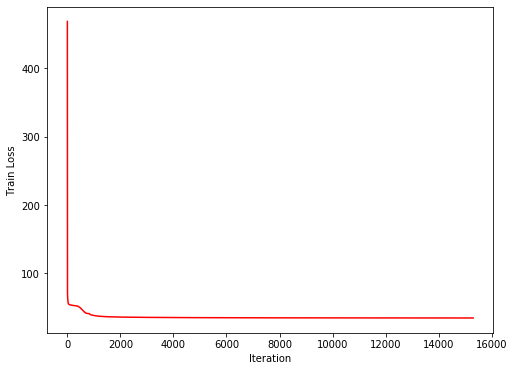

In [563]:
def ALS(henry_matrix, f, lambd, threshold, convergence=1e-5, verbose=True):
    n = 0
    train_error_arr = []
    train_error = np.inf
    prev_error = 0
    convergence_cnt = 0
    mu = np.nanmean(henry_matrix)
    b_i = np.nanmean(henry_matrix, axis=0) - mu
    b_u = np.nanmean(henry_matrix, axis=1) - mu
    
    M = (np.random.rand(f, henry_matrix.shape[0])-0.5)*0.1
    G = (np.random.rand(f, henry_matrix.shape[1])-0.5)*0.1
    print('X_shape: {}\tY_shape: {}'.format(M.shape, G.shape))
    while train_error > threshold:
        for j in range(M.shape[1]):
            B = mu + b_u[j] + b_i
            mask = ~np.isnan(henry_matrix[j,:])
            M[:,j] = ((henry_matrix[j,:][mask]-B[mask]).dot(G[:,mask].T)).dot(np.linalg.inv(G[:,mask].dot(G[:,mask].T)) + lambd * np.identity(f))
        for j in range(G.shape[1]):
            B = mu + b_i[j] + b_u
            mask = ~np.isnan(henry_matrix[:,j])
            G[:,j] = np.linalg.inv(M[:,mask].dot(M[:,mask].T) + lambd * np.identity(f)).dot(M[:,mask]).dot(henry_matrix[:,j][mask]-B[mask])
                
        #print(tf.math.subtract(henry_matrix, tf.matmul(np.transpose(X), Y)))
        pred = predict_all(M, G, mu, b_i, b_u)[~np.isnan(henry_matrix)].flatten()
        actual = henry_matrix[~np.isnan(henry_matrix)].flatten()
        #print(pred)
        prev_error = train_error
        train_error = np.sqrt(np.sum([(actual[i] - pred[i])**2 for i in range(len(pred))])/len(pred))
        train_error_arr.append(train_error)
        error_diff = prev_error - train_error
        if n % 1000 == 0:
            print('Train Error on iteration {}: {}\n-------------'.format(n, train_error))
            
        if error_diff < convergence:
            convergence_cnt += 1
            if convergence_cnt > 4:
                print('Training has converged after {} iterations. See `convergence` parameter for convergence procedure.'.format(n))
                print('Train error: {}'.format(train_error))
                break
        else:
            convergence_cnt = 0
        n += 1
    
    fig, ax = plt.subplots(figsize=(8,6))
    #ax.scatter(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.plot(np.arange(len(train_error_arr)), train_error_arr, color='red')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Train Loss')
    plt.show()
    
    return M.T, G, mu, b_i, b_u
p,q,mu,b_i,b_u = ALS(henry_df.values, 3, 10.3, 0.01)

In [591]:
h = p.dot(q)
i = 9
j = 9
h[i,j] + mu + b_i[i] + b_u[j]

1.3240902624856403

In [592]:
henry_df.values[i,j]

0.7097341380537214

In [240]:
np.where(~np.isnan(henry_df.values[4,:]))[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 20, 21, 25])

In [253]:
a = np.array(([1], [2], [3], [4]))
b = np.array([[1,1,1,1,1],])
print('a shape: {}, b shape: {}'.format(a.shape, b.shape))

ab = np.matmul(a, b)
print('ab shape: {}'.format(ab.shape))
ab

a shape: (4, 1), b shape: (1, 5)
ab shape: (4, 5)


array([[1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]])

In [254]:
Y[:,0].shape

(2,)

In [257]:
yi = Y[:,0].reshape((2,1))

In [295]:
tf.matmul(yi, np.transpose(yi))

<tf.Tensor: id=35, shape=(2, 2), dtype=float64, numpy=
array([[0.96807413, 0.79354549],
       [0.79354549, 0.65048164]])>

In [274]:
j = 0
f = 2
comp05 = [Y[:,i].reshape((f, 1)) * np.transpose(Y[:,i]).reshape((1, f)) for i in np.where(~np.isnan(henry_df.values[j, :]))[0]]

In [307]:
x = tf.math.add_n(comp05)

In [293]:
summ = 0
for val in comp05:
    summ += val[0,0]
print(summ)

6.123233048651876


In [312]:
tf.reshape(x, (4,))

<tf.Tensor: id=597, shape=(4,), dtype=float64, numpy=array([6.12323305, 3.69262422, 3.69262422, 4.28796079])>

In [333]:
train_error = [j for (i, j) in [np.where(~np.isnan(henry_df.values))]]

In [337]:
henry_matrix = henry_df.values

In [345]:
Z = tf.matmul(np.transpose(X),Y)

In [353]:
np.sqrt(np.nansum(tf.math.subtract(henry_matrix, Z)**2)/np.count_nonzero(~np.isnan(henry_matrix)))

1180.0244736624365